# Código Python - Trabalho 2

## *Imports* estáticos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

## 4.1  Análise Exploratória de Dados
### 4.1.1   Leitura do ficheiro

In [3]:
dados = pd.read_csv('../../dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']).rename(columns={"Value":"Premature_Deaths"})
#dados = dados[dados.Country != 'All Countries']
#dados.sort_values(by=['Value'])

### 4.1.4. Agrupamento dos dados em zonas

In [4]:
soutEuDados = dados[dados['Country'].isin(['Greece', 'Spain', 'Italy', 'Portugal'])]
soutEuDados

,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
1274,Greece,EL643,PM2.5,Chronic obstructive pulmonary disease,15469.0,243.2,7.6,0.0
1548,Portugal,PT16H,PM2.5,Chronic obstructive pulmonary disease,67529.0,1098.3,5.8,0.0
1552,Spain,ES417,PM2.5,Chronic obstructive pulmonary disease,72931.0,610.6,5.2,0.0
3094,Greece,EL412,PM2.5,Chronic obstructive pulmonary disease,26702.0,232.2,9.0,1.0
3096,Greece,EL621,PM2.5,Chronic obstructive pulmonary disease,27037.0,184.4,9.2,1.0
...,...,...,...,...,...,...,...,...
47743,Italy,IT,PM2.5,Chronic obstructive pulmonary disease,45750394.0,169657.2,11.7,4166.0
47763,Italy,IT,PM2.5,Lung cancer,45750394.0,169657.2,11.7,5373.0
47780,Italy,IT,PM2.5,Diabetes Mellitus,45750394.0,169657.2,11.7,9805.0
47787,Italy,IT,PM2.5,Ischemic heart disease,45750394.0,169657.2,11.7,10789.0


### 4.2.3 K-Fold cross validation

#### Preparação dos valores

In [5]:
goalAttrib = 'Premature_Deaths'
features = list(dados.columns[0:8])
numericFeatures = features[4:]
scaler = MinMaxScaler()

X = soutEuDados[numericFeatures].drop(columns=[goalAttrib])
y = soutEuDados[goalAttrib]

#### Otimização dos parâmetros da Árvore de regressão e visualização

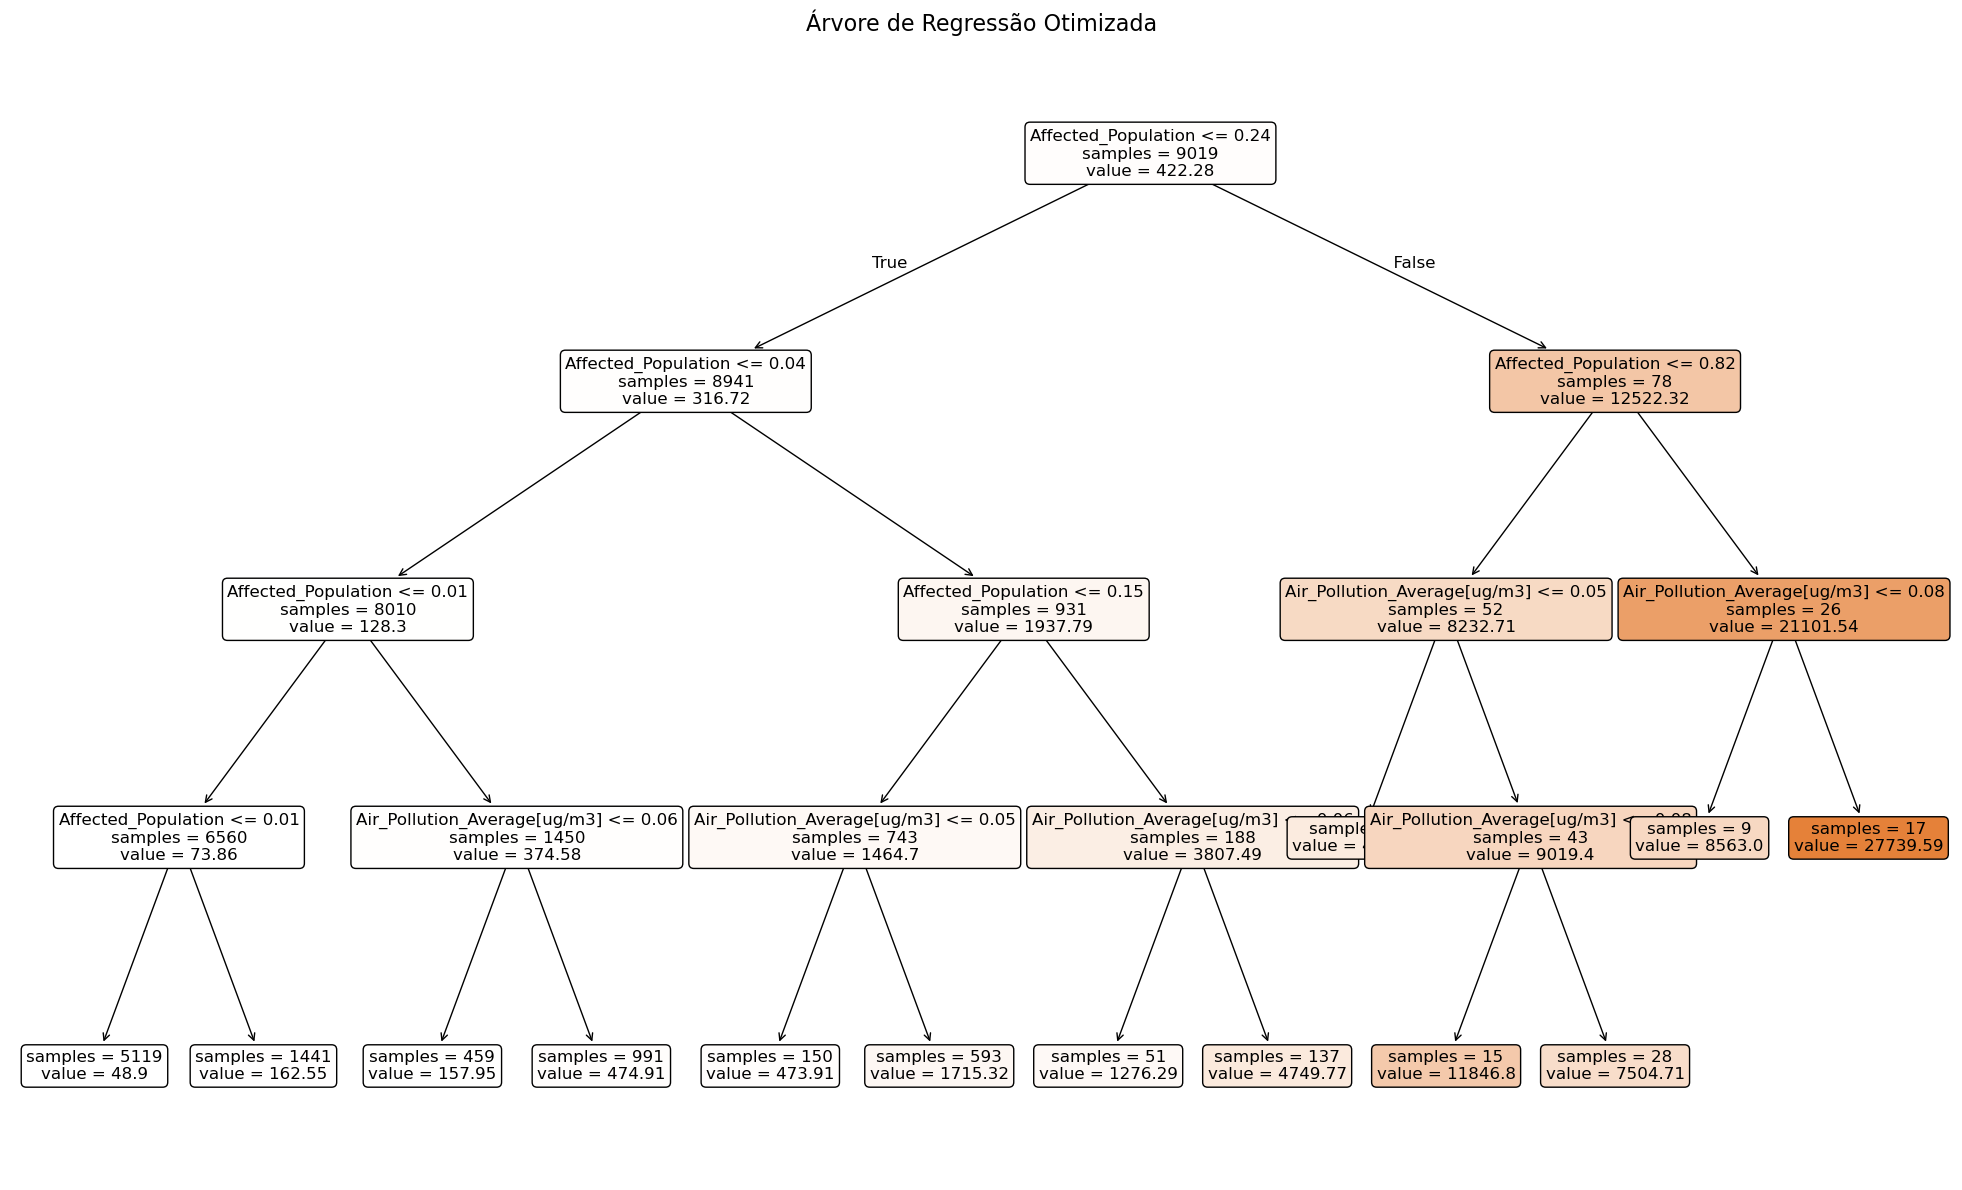

In [6]:
tree_params = {
    'dtr__max_depth': [4, 6, 8, None],
    'dtr__min_samples_split': [2, 5, 10],
    'dtr__min_samples_leaf': [1, 2, 4]
}
tree_pipeline = Pipeline([
    ('scaler', scaler),
    ('dtr', DecisionTreeRegressor(random_state=42))
])
tree_grid = GridSearchCV(tree_pipeline, tree_params, cv=3,
                         scoring='neg_mean_squared_error', n_jobs=-1)
tree_grid.fit(X, y)

#----------------------------

plt.figure(figsize=(20, 12))  

plot_tree(
    tree_grid.best_estimator_.named_steps['dtr'],
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=12,
    proportion=False,
    impurity=False,
    precision=2
)

plt.title("Árvore de Regressão Otimizada", fontsize=16)
plt.tight_layout()
plt.show()

#### Otimização do kernel SVM

In [7]:
svm_pipeline = Pipeline([
    ('scaler', scaler),
    ('svm', SVR())
])

svm_params = {
    'svm__kernel': ['rbf'],
    'svm__C': [1, 10],
    'svm__epsilon': [0.1, 0.2]
}

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5,
                        scoring='neg_mean_squared_error', n_jobs=-1)
svm_grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 10], 'svm__epsilon': [0.1, 0.2],
                         'svm__kernel': ['rbf']},
             scoring='neg_mean_squared_error')

#### Otimização da configuração da rede neuronal

In [8]:
mlp_params = {
    'mlp__hidden_layer_sizes': [(50,), (100,)],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam'],
    'mlp__learning_rate': ['constant']
}
mlp_pipeline = Pipeline([
    ('scaler', scaler),
    ('mlp', MLPRegressor(max_iter=5000, early_stopping=True, random_state=42))
])
mlp_grid = GridSearchCV(mlp_pipeline, mlp_params, cv=3,
                        scoring='neg_mean_squared_error', n_jobs=-1)
mlp_grid.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('mlp',
                                        MLPRegressor(early_stopping=True,
                                                     max_iter=5000,
                                                     random_state=42))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['relu'],
                         'mlp__hidden_layer_sizes': [(50,), (100,)],
                         'mlp__learning_rate': ['constant'],
                         'mlp__solver': ['adam']},
             scoring='neg_mean_squared_error')

#### k-fold cross validation

In [10]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

models = []
models.append(('rgr', Pipeline([
    ('scaler', scaler),
    ('lr', LinearRegression())
])))
models.append(('dtr', tree_grid.best_estimator_))
models.append(('net', mlp_grid.best_estimator_))
models.append(('svm', svm_grid.best_estimator_))

lstresults = []
rmse_scores_array = []
mae_scores_array = []

for name, model in models:
    rmse_scores = cross_val_score(model, X, y, cv=kfold,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    mae_scores = cross_val_score(model, X, y, cv=kfold,
                                 scoring='neg_mean_absolute_error', n_jobs=-1)
    rmse_scores_array.append(rmse_scores)
    mae_scores_array.append(mae_scores)
    mae = (-mae_scores)
    rmse = (-rmse_scores) ** 0.5
    lstresults.append(pd.Series({
        'model': name,
        'mean_mae': round(mae.mean(), 3),
        'std_mae': round(mae.std(), 3),
        'mean_rmse': round(rmse.mean(), 3),
        'std_rmse': round(rmse.std(), 3),
    }))

resdf = pd.DataFrame(lstresults)
resdf

,model,mean_mae,std_mae,mean_rmse,std_rmse
0,rgr,447.851,19.227,1973.718,352.331
1,dtr,419.851,20.798,1892.906,291.569
2,net,451.383,26.682,1974.829,433.163
3,svm,374.670,31.351,2289.983,511.069


### 4.2.4 - Identificar os melhores modelos com base no MAE e no RMSE

In [11]:
# Ordenar os modelos pelo menor MAE
resdf_mae_sorted = resdf.sort_values(by='mean_mae')
print("Modelos ordenados pelo menor MAE:")
print(resdf_mae_sorted[['model', 'mean_mae']])

# Ordenar os modelos pelo menor RMSE
resdf_rmse_sorted = resdf.sort_values(by='mean_rmse')
print("\nModelos ordenados pelo menor RMSE:")
print(resdf_rmse_sorted[['model', 'mean_rmse']])

Modelos ordenados pelo menor MAE:
  model  mean_mae
3   svm   374.670
1   dtr   419.851
0   rgr   447.851
2   net   451.383

Modelos ordenados pelo menor RMSE:
  model  mean_rmse
1   dtr   1892.906
0   rgr   1973.718
2   net   1974.829
3   svm   2289.983


### 4.2.5 - Justificar se os dois melhores modelos são estatisticamente significativos para um nível de significância de 5%.

In [17]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

dtr_results = rmse_scores_array[1]
rgr_results = rmse_scores_array[0]

t_stat, p_value = shapiro(dtr_results)
t_stat, p_value1 = shapiro(rgr_results)

print("Teste de Shapiro-Wilk para os resultados do DecisionTreeRegressor:", p_value)
print("Teste de Shapiro-Wilk para os resultados do LinearRegression:", p_value1)

if (p_value > 0.05) and (p_value1 > 0.05):
    print("Os resultados de ambos os modelos seguem uma distribuição normal.")
    t_stat, p_value_t = ttest_ind(dtr_results, rgr_results, equal_var=False)
    print("Teste T-Student:", p_value_t)

    if p_value_t < 0.05:
        print("Existe uma diferença estatisticamente significativa entre os resultados dos dois modelos.")
    else:
        print("Não existe diferença estatisticamente significativa entre os resultados dos dois modelos.")
else:
    print("Pelo menos um dos resultados dos modelos não segue uma distribuição normal.")
    u_stat, p_value_u = mannwhitneyu(dtr_results, rgr_results)
    print("Teste de Mann-Whitney U:", p_value_u)

    if p_value_u < 0.05:
        print("Existe uma diferença estatisticamente significativa entre os resultados dos dois modelos.")
    else:
        print("Não existe diferença estatisticamente significativa entre os resultados dos dois modelos.")

Teste de Shapiro-Wilk para os resultados do DecisionTreeRegressor: 0.28698961546844526
Teste de Shapiro-Wilk para os resultados do LinearRegression: 0.822023987040241
Os resultados de ambos os modelos seguem uma distribuição normal.
Teste T-Student: 0.709311687178699
Não existe diferença estatisticamente significativa entre os resultados dos dois modelos.
